# Gaussian Mixture Models (GMMs)

## Introduction

Gaussian Mixture Models (GMMs) are a powerful and flexible tool for modeling complex probability distributions by combining multiple Gaussian distributions. They are widely used in various applications, including clustering, density estimation, and pattern recognition.

## Basic Concept

A GMM represents a probability distribution as a weighted sum of K Gaussian components:

$$p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

where:
- $\pi_k$ are the mixing coefficients (weights) with $\sum_{k=1}^K \pi_k = 1$
- $\mathcal{N}(x | \mu_k, \Sigma_k)$ is the Gaussian distribution with mean $\mu_k$ and covariance $\Sigma_k$

## Model Parameters

The parameters of a GMM are:
- $\pi_k$: mixing coefficients
- $\mu_k$: mean vectors
- $\Sigma_k$: covariance matrices

for $k = 1, ..., K$, where K is the number of components.

## Latent Variable Representation

We can introduce a latent variable $z$ to simplify the model:

$$p(x, z) = p(z)p(x|z) = \prod_{k=1}^K (\pi_k \mathcal{N}(x | \mu_k, \Sigma_k))^{z_k}$$

where $z$ is a one-hot encoded vector indicating which component generated the data point.

## Expectation-Maximization (EM) Algorithm for GMMs

The EM algorithm is used to estimate the parameters of a GMM. It consists of two steps:

### E-step: Compute responsibilities

For each data point $x_n$ and each component $k$:

$$\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n | \mu_j, \Sigma_j)}$$

### M-step: Update parameters

Update the parameters using the computed responsibilities:

$$N_k = \sum_{n=1}^N \gamma(z_{nk})$$

$$\pi_k^{new} = \frac{N_k}{N}$$

$$\mu_k^{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})x_n$$

$$\Sigma_k^{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})(x_n - \mu_k^{new})(x_n - \mu_k^{new})^T$$


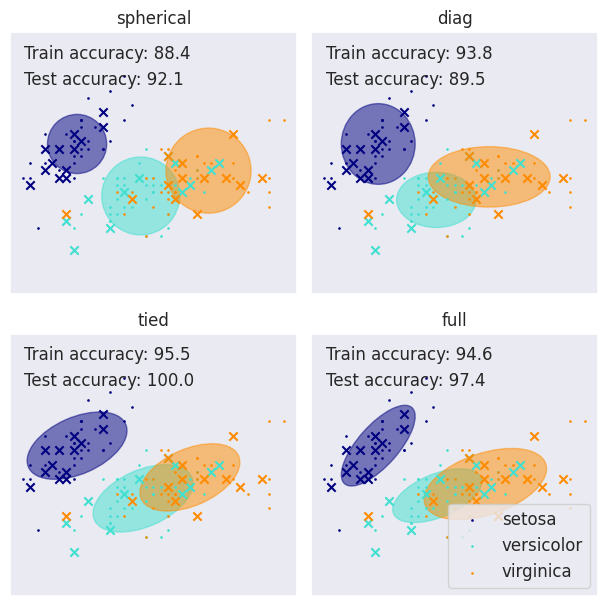

In [3]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "turquoise", "darkorange"]




def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6), dpi=100)
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()


## Initialization Strategies

The performance of the EM algorithm can be sensitive to initialization. Common strategies include:

1. Random initialization
2. K-means clustering initialization
3. Random subset initialization


Automatically created module for IPython interactive environment


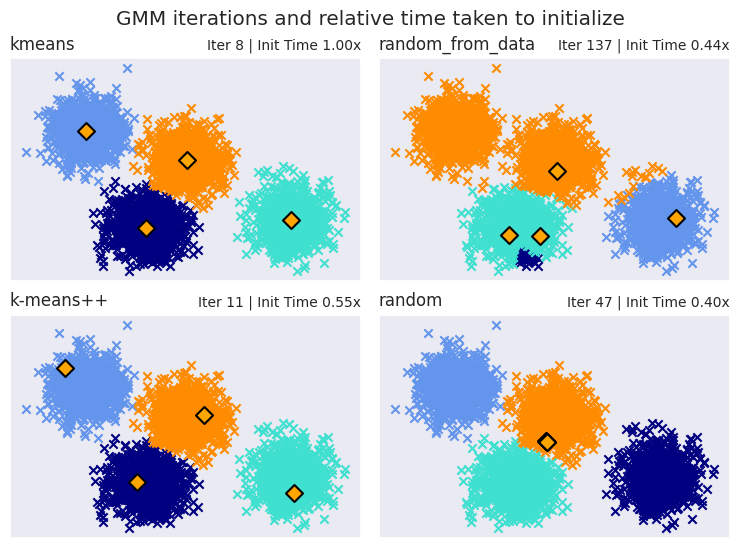

In [4]:
# Author: Gordon Walsh <gordon.p.walsh@gmail.com>
# Data generation code from Jake Vanderplas <vanderplas@astro.washington.edu>

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets._samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms

print(__doc__)

# Generate some data

X, y_true = make_blobs(n_samples=4000, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]

n_samples = 4000
n_components = 4
x_squared_norms = row_norms(X, squared=True)


def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = GaussianMixture(
        n_components=4, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_


methods = ["kmeans", "random_from_data", "k-means++", "random"]
colors = ["navy", "turquoise", "cornflowerblue", "darkorange"]
times_init = {}
relative_times = {}

plt.figure(figsize=(4 * len(methods) // 2, 6), dpi=100)
plt.subplots_adjust(
    bottom=0.1, top=0.9, hspace=0.15, wspace=0.05, left=0.05, right=0.95
)

for n, method in enumerate(methods):
    r = np.random.RandomState(seed=1234)
    plt.subplot(2, len(methods) // 2, n + 1)

    start = timer()
    ini = get_initial_means(X, method, r)
    end = timer()
    init_time = end - start

    gmm = GaussianMixture(
        n_components=4, means_init=ini, tol=1e-9, max_iter=2000, random_state=r
    ).fit(X)

    times_init[method] = init_time
    for i, color in enumerate(colors):
        data = X[gmm.predict(X) == i]
        plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")

    plt.scatter(
        ini[:, 0], ini[:, 1], s=75, marker="D", c="orange", lw=1.5, edgecolors="black"
    )
    relative_times[method] = times_init[method] / times_init[methods[0]]

    plt.xticks(())
    plt.yticks(())
    plt.title(method, loc="left", fontsize=12)
    plt.title(
        "Iter %i | Init Time %.2fx" % (gmm.n_iter_, relative_times[method]),
        loc="right",
        fontsize=10,
    )
plt.suptitle("GMM iterations and relative time taken to initialize")
plt.show()


## Choosing the Number of Components

Selecting the appropriate number of components K is crucial. Methods include:

1. Cross-validation
2. Bayesian Information Criterion (BIC)
3. Akaike Information Criterion (AIC)


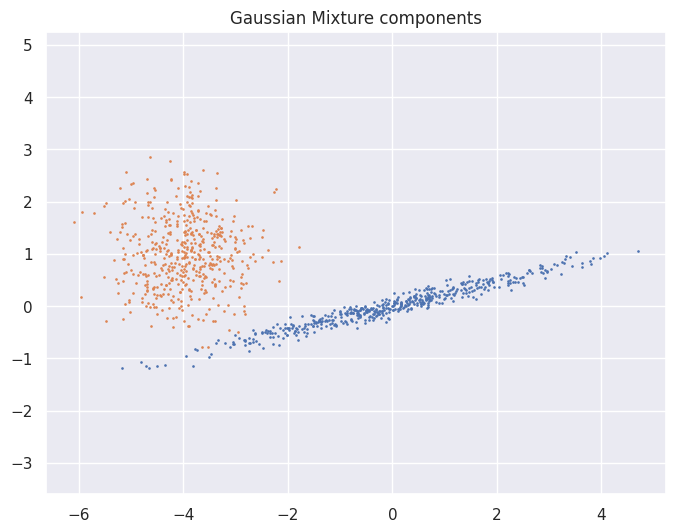

In [7]:
# Author: Gordon Walsh <gordon.p.walsh@gmail.com>
# Data generation code from Jake Vanderplas <vanderplas@astro.washington.edu>

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


n_samples = 500
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
component_1 = np.dot(np.random.randn(n_samples, 2), C)  # general
component_2 = 0.7 * np.random.randn(n_samples, 2) + np.array([-4, 1])  # spherical

X = np.concatenate([component_1, component_2])

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(component_1[:, 0], component_1[:, 1], s=0.8)
plt.scatter(component_2[:, 0], component_2[:, 1], s=0.8)
plt.title("Gaussian Mixture components")
plt.axis("equal")
plt.show()

## Bayesian Information Criterion (BIC)

The Bayesian Information Criterion (BIC) is a model selection criterion used to choose the best model among a set of candidate models. In the context of Gaussian Mixture Models, it's often used to determine the optimal number of components.

### Definition

For a GMM with K components and D-dimensional data, the BIC score is defined as:

$$BIC = -2 \ln(\hat{L}) + M \ln(N)$$

where:
- $\hat{L}$ is the maximum likelihood estimate of the model
- $N$ is the number of data points
- $M$ is the number of free parameters in the model

For a GMM, the number of free parameters $M$ is:

$$M = K(D + \frac{1}{2}D(D+1)) + (K-1)$$

where:
- $K(D)$ is for the means
- $K(\frac{1}{2}D(D+1))$ is for the covariance matrices
- $(K-1)$ is for the mixing coefficients

### Interpretation

- The first term $-2 \ln(\hat{L})$ rewards models that fit the data well (higher likelihood).
- The second term $M \ln(N)$ penalizes model complexity to prevent overfitting.

### Model Selection

To use BIC for model selection:

1. Fit GMMs with different numbers of components (K).
2. Calculate the BIC score for each model.
3. Choose the model with the lowest BIC score.

### Advantages

- Balances model fit and complexity
- Tends to favor simpler models compared to AIC
- Consistent estimator (selects the true model with probability approaching 1 as N → ∞)

### Limitations

- Assumes large sample sizes
- May underestimate the number of components in some cases

### Comparison with AIC

The Akaike Information Criterion (AIC) is similar to BIC but with a different penalty term:

$$AIC = -2 \ln(\hat{L}) + 2M$$

BIC penalizes model compl

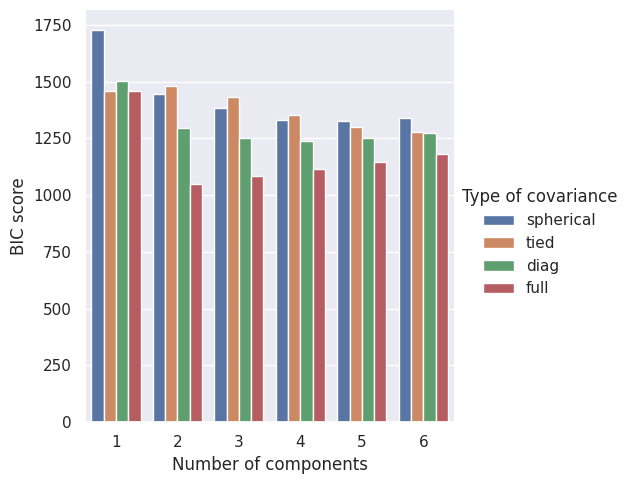

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)

import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

# %%
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

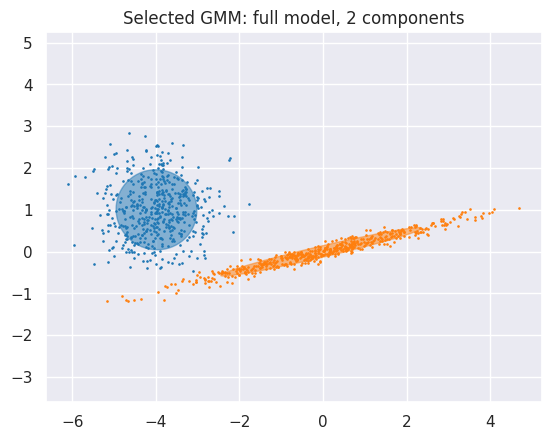

In [10]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(X)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()


## Applications of GMMs

1. Clustering
2. Density estimation
3. Anomaly detection
4. Speech recognition
5. Image segmentation

## Advantages and Limitations

Advantages:
- Flexible modeling of complex distributions
- Soft clustering capabilities
- Interpretable parameters

Limitations:
- Sensitive to initialization
- May converge to local optima
- Curse of dimensionality in high-dimensional spaces

## Extensions and Variants

1. Variational Bayesian GMMs
2. Infinite GMMs using Dirichlet processes
3. Mixtures of Factor Analyzers for high-dimensional data